In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from tqdm import tqdm

import pyroomacoustics as pra
import itertools
import sklearn.metrics as sk_metrics


from pathlib import Path

import shamans.utils.eval_utils as eval

In [33]:
metrics_angular_threshold = 10
n_sources = 7
thresholds_ang_spec = [0., 0.05, 0.1, 0.2, 0.5, 0.6, 0.8, 0.9, 1.0]

Used the data of experiment 3, but use threshold to find the number of sources.

In [34]:
# merge all the csv fo the experiments 1 for different runs
def merge_csvs_and_get_dataframe(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*.csv')]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
    combined_csv.to_csv(path_to_results / f"experiment_results_exp-{exp_id}_all_runs.csv", index=False, encoding='utf-8-sig')
    return combined_csv

def merge_pickles_and_get_dict(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*_with_ang_specs.pkl')]
    combined_dicts = []
    for filename in tqdm(all_filenames):
        with open(filename, 'rb') as f:
            combined_dicts += pickle.load(f)
    with open(path_to_results / f"experiment_results_exp-{exp_id}_all_runs_with_ang_specs.pkl", 'wb') as f:
        pickle.dump(combined_dicts, f)
    return combined_dicts

In [35]:
# load data
exp_id = 3
path_to_results = Path('results/')
exp_df = merge_csvs_and_get_dataframe(exp_id, path_to_results)
ang_specs = merge_pickles_and_get_dict(exp_id, path_to_results)

100%|██████████| 8/8 [00:00<00:00, 21.63it/s]


In [36]:
exp_df.columns

Index(['exp_name', 'time', 'record_id', 'num_srcs', 'src_ids', 'doas_est_idx',
       'doas_ref_idx', 'doas_ref_az', 'doas_est_az', 'doas_ref_el',
       'doas_est_el', 'errors', 'speech_files', 'frame_id', 'target_doa',
       'n_sources', 'duration', 'snr', 'noise_type', 'rt60', 'mc_seed',
       'method_id', 'loc_method', 'freq_min', 'freq_max', 'sv_method', 'nObs',
       'seed', 'sv_normalization'],
      dtype='object')

In [37]:
exp_df['loc_method_simple'] = exp_df['loc_method'].apply(lambda x: x.split('-')[0])

best_seed = 666
# rename ref_8 and alg_6 to ref and alg
exp_df = exp_df.assign(sv_model=exp_df['sv_method'] + '_' + exp_df['nObs'].astype(str))
exp_df = exp_df.assign(loc_algo=exp_df['loc_method'].str[:3])
exp_df['sv_model'] = exp_df['sv_model'].str.replace('ref_8', 'ref')
exp_df['sv_model'] = exp_df['sv_model'].str.replace('alg_8', 'alg')
exp_df.loc[exp_df['sv_model'] == 'ref', 'seed'] = 666
exp_df.loc[exp_df['sv_model'] == 'alg', 'seed'] = 666

exp_df = exp_df[
    (exp_df['n_sources'] == n_sources)
    & (exp_df['loc_method'].isin([
        'srp_phat', 
        'music_s-1', 
        'music_s-4', 
        # # 'music_s-5', 
        # # 'music_s-6', 
        'alpha-2.0_beta-2_eps-1E-3_iter-500',
        'alpha-1.2_beta-2_eps-1E-3_iter-500',
        'alpha-1.2_beta-1_eps-1E-3_iter-500',
        'alpha-1.2_beta-0_eps-1E-3_iter-500',
        ]))
    # & (exp_df['sv_method'].isin(['ref', 'alg']))
    & (exp_df['seed'] == 666)
    & (exp_df['duration'] == 1)
    & (exp_df['rt60'] > -1)
]
print(len(exp_df))

# laod picke file with the ground truth
with open(path_to_results / 'experiment_results_exp-3_all_runs_with_ang_specs.pkl', 'rb') as f:
    list_of_ang_specs = pickle.load(f)
    
print(exp_df.shape)
print(len(list_of_ang_specs))

doa_grid_rad = np.deg2rad(np.arange(0, 360, 6))

8232
(8232, 32)
11760


In [38]:
unique_frame_ids = exp_df['frame_id'].unique()
print(len(unique_frame_ids))
unique_method_ids = exp_df['method_id'].unique()
print(len(unique_method_ids))

24
49


In [39]:
print(unique_method_ids)

['alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True'
 'alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_alg_nObs-8_seed-13_norm-True'
 'alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True'
 'alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-16_seed-666_norm-True'
 'alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-32_seed-666_norm-True'
 'alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-64_seed-666_norm-True'
 'alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-128_seed-666_norm-True'
 'alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True'
 'alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_alg_nObs-8_seed-13_norm-True'
 'alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True'
 'alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-16_seed-666_norm-True'
 'a

In [40]:
# initialize the dict with the frame ids
ang_specs_dicts = {}
for frame_id in unique_frame_ids:
    ang_specs_dicts[frame_id] = {}
    for method_id in unique_method_ids:
        ang_specs_dicts[frame_id][method_id] = None

for d in tqdm(list_of_ang_specs):
    if not d['frame_id'] in unique_frame_ids:
        continue
    if not d['method_id'] in unique_method_ids:
        continue
    # add the method id to the frame id
    ang_specs_dicts[d['frame_id']][d['method_id']] = d
    
# check if all the frames are there
missing_frames = []
retrieve_frames = []
for frame_id in unique_frame_ids:
    for method_id in unique_method_ids:
        if ang_specs_dicts[frame_id][method_id] is None:
            missing_frames.append((frame_id))
        else:
            retrieve_frames.append((frame_id))
            
print("Missing:", len(np.unique(missing_frames)))
print(np.unique(missing_frames))
print("Retrieved:", len(np.unique(retrieve_frames)))
print(np.unique(retrieve_frames))

100%|██████████| 11760/11760 [00:00<00:00, 334169.00it/s]

Missing: 0
[]
Retrieved: 24
['nSrc-7_doas-[10 45 20 52 55 15 35]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.0_mc-6'
 'nSrc-7_doas-[10 45 20 52 55 15 35]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-6'
 'nSrc-7_doas-[10 45 20 52 55 15 35]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.273_mc-6'
 'nSrc-7_doas-[45 14 57 48 16  9 37]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.0_mc-5'
 'nSrc-7_doas-[45 14 57 48 16  9 37]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-5'
 'nSrc-7_doas-[45 14 57 48 16  9 37]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.273_mc-5'
 'nSrc-7_doas-[47 53 12  8  5 15  0]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.0_mc-1'
 'nSrc-7_doas-[47 53 12  8  5 15  0]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-1'
 'nSrc-7_doas-[47 53 12  8  5 15  0]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.273_mc-1'
 'nSrc-7_doas-[50 15 55  8 22 53 18]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-

In [41]:
assert len(ang_specs_dicts.keys()) == len(unique_frame_ids), f"{len(ang_specs_dicts.keys())} != {len(unique_frame_ids)}"

In [42]:
def detect_peaks(values):
    # make circular
    n_points = len(values)
    val_ext = np.append(values, values[:10])

    # run peak finding
    indexes = pra.doa.detect_peaks(val_ext, show=False) % n_points
    candidates = np.unique(indexes)  # get rid of duplicates, if any
    return candidates

In [43]:
df_results = pd.DataFrame()

for thr in thresholds_ang_spec:
    
    for frame_id in tqdm(unique_frame_ids, desc='Iterating over frames for thr={}'.format(thr)):
        
        for method_id in unique_method_ids:
            
            ang_spec = ang_specs_dicts[frame_id][method_id]['ang_spec']
            assert len(ang_spec.shape) == 2
            assert ang_spec.shape[0] == len(doa_grid_rad)
            ang_spec = np.mean(np.array(ang_spec), -1)
            ang_spec = ang_spec / np.max(ang_spec)
            
            # set the threshold
            ang_spec[ang_spec < thr] = 0
            
            # find peaks
            peaks = detect_peaks(ang_spec)     
            
            df_ = pd.DataFrame({
                'frame_id': frame_id,
                "method_id": method_id,
                'thresholds_ang_spec': thr,
                'peaks_locations': peaks.tolist(),
                'peaks_ids' : [f'p{i}' for i in range(len(peaks))],
                'n_peaks': len(peaks)
            })
            df_results = pd.concat([df_results, df_], ignore_index=True)
        
print(len(df_results))

Iterating over frames for thr=1.0: 100%|██████████| 24/24 [00:01<00:00, 22.85it/s]

48437


In [44]:
# merge the results_df with the exp_df on the frame_id and method_id
df_merge = exp_df.merge(df_results, on=['frame_id', 'method_id'])
print(len(df_merge))

339059


In [45]:
results_thr_list = []

for frame_id in tqdm(unique_frame_ids, desc='Iterating over frames'):
    for method_id in unique_method_ids:
        
        df_ = df_merge.loc[
            (df_merge['frame_id'] == frame_id) 
            & (df_merge['method_id'] == method_id)
        ]
        
        thrs = df_['thresholds_ang_spec'].unique()
        
        for thr in thrs:
            
            n_sources = df_.loc[df_['thresholds_ang_spec'] == thr, 'n_sources'].unique()
            
            assert len(n_sources) == 1
            n_sources = n_sources[0]
            
            estimated_peaks_loc = df_.loc[df_['thresholds_ang_spec'] == thr, 'peaks_locations'].unique()
            estimated_azimuths = np.rad2deg(doa_grid_rad[estimated_peaks_loc])
            target_azimuths = np.rad2deg(df_.loc[df_['thresholds_ang_spec'] == thr, 'doas_ref_az'].unique())
            
            n_estimated = len(estimated_azimuths)
            n_target = len(target_azimuths)
            assert n_target == n_sources, f"{n_target} != {n_sources} \n {frame_id}"
            
            metrics = eval.compute_metrics(estimated_azimuths, target_azimuths, metrics_angular_threshold, np.rad2deg(doa_grid_rad))
            
            # print(metrics['TP'], metrics['FP'], metrics['FN'], metrics['TN'])
            
            # check that tpr and fpr are not nans
            if np.isnan(metrics['tpr']) or np.isnan(metrics['fpr']):
                print(frame_id)
                print(estimated_azimuths)
                print(target_azimuths)
                print(n_sources)
                print(method_id)
                print(df_.loc[df_['thresholds_ang_spec'] == thr])
                raise ValueError('TPR or FPR is nan')
            
            
            if len(target_azimuths) > n_sources:
                print(frame_id)
                print(estimated_azimuths)
                print(target_azimuths)
                print(n_sources)
                print(method_id)
                print(df_.loc[df_['thresholds_ang_spec'] == thr])
                raise ValueError('True positives greater than n_sources')
            
            metrics['frame_id'] = frame_id
            metrics['method_id'] = method_id
            metrics['metrics_angular_threshold'] = metrics_angular_threshold
            metrics['thresholds_ang_spec'] = float(thr)
            
            results_thr_list.append(metrics)
        
df_results_thr_ = pd.DataFrame(results_thr_list)

Iterating over frames: 100%|██████████| 24/24 [00:40<00:00,  1.70s/it]


In [46]:
df_results_thr = df_results_thr_.merge(df_merge, on=['frame_id', 'method_id', 'thresholds_ang_spec'])
df_results_thr[:100].to_csv('asd.csv', index=False)
len(df_results_thr)

print(len(df_merge['method_id'].unique()))
print(len(df_results_thr_['method_id'].unique()))
print(len(df_results_thr['method_id'].unique()))

49
49
49


In [ ]:
thrs = np.sort(df_['thresholds_ang_spec'].unique())[::-1]
print(thrs)

auc_df = pd.DataFrame()

for rt60 in df_results_thr['rt60'].unique():

    # plt.figure(figsize=(8, 6))
    # plt.title(f'ROC curve for RT60={rt60}')
    
    for method_id in unique_method_ids:

        tpr_list = []
        fpr_list = []
        f1_list = []
        
        for t, thr in enumerate(thrs):
            
            df_ = df_results_thr.loc[
                    (df_results_thr['method_id'] == method_id)
                    & (df_results_thr['rt60'] == rt60)
                ]
            
            loc_method = df_['loc_method'].unique()
            sv_method = df_['sv_method'].unique()
            assert len(sv_method) == 1
            sv_method = sv_method[0]
            assert len(loc_method) == 1
            loc_method = loc_method[0]
            nObs = df_['nObs'].unique()
            assert len(nObs) == 1
            nObs = nObs[0]
                                    
            # micro-averaging over the frames
            TP = FP = FN = TN = 0.0
            tpr_list_ = []
            fpr_list_ = []
                        
            for frame_id in df_['frame_id'].unique():
                
                df__ = df_[(df_['frame_id'] == frame_id)]
                    
                TPs = df__[df__['thresholds_ang_spec'] == thr]['TP'].unique()
                FPs = df__[df__['thresholds_ang_spec'] == thr]['FP'].unique()
                FNs = df__[df__['thresholds_ang_spec'] == thr]['FN'].unique()
                TNs = df__[df__['thresholds_ang_spec'] == thr]['TN'].unique()
                peaks_id = df__[df__['thresholds_ang_spec'] == thr]['peaks_ids'].values
                
                tpr = df__[df__['thresholds_ang_spec'] == thr]['tpr'].unique()
                fpr = df__[df__['thresholds_ang_spec'] == thr]['fpr'].unique()
                
                # check that tpr and fpr are not nans
                if np.isnan(TPs) or np.isnan(FPs) or np.isnan(FNs) or np.isnan(TNs):
                    print(frame_id)
                    print(peaks_id)
                    print(TPs, FPs, FNs, TNs)
                    print(method_id)
                    print(df__)
                    raise ValueError('TPR or FPR is nan')
                
                assert len(np.unique(TPs)) == len(np.unique(FPs)) == len(np.unique(FNs)) == len(np.unique(TNs)) == 1
                assert len(np.unique(tpr)) == len(np.unique(fpr)) == 1
                
                TP += TPs[0]
                FP += FPs[0]
                FN += FNs[0]
                TN += TNs[0]
                                            
                tpr_list_.append(tpr[0])
                fpr_list_.append(fpr[0])
                
            
            # import ipdb; ipdb.set_trace()
            tpr = TP / (TP + FN)
            fpr = FP / (FP + TN)
            f1 = 2 * TP / (2 * TP + FP + FN)
            
            tpr_list.append(np.mean(tpr_list_))
            fpr_list.append(np.mean(fpr_list_))
            f1_list.append(f1)
            
        # plot ROC curve
        
        tpr_list = [0] + tpr_list + [1]
        fpr_list = [0] + fpr_list + [1]
        
        label = method_id
        
        # compute AUC
        auc = np.trapezoid(tpr_list, fpr_list)
        auc_sk = sk_metrics.auc(fpr_list, tpr_list)
        
        auc_df_ = pd.DataFrame({
            'loc_method': loc_method,
            'sv_method': sv_method,
            'nObs': nObs,
            'method_id': method_id,
            'auc': auc,
            'auc_sk': auc_sk,
            'rt60': rt60,
            'f1' : np.max(f1_list),
            'ang_spec_thr': metrics_angular_threshold
        }, index=[0])
        auc_df = pd.concat([auc_df, auc_df_], ignore_index=True)
        
        print(f'AUC for {label} is {auc:0.3f}')
        
        label = loc_method + ' ' + sv_method + ' ' + str(nObs)
        # if 'alpha' in loc_method:
        #     plt.step(fpr_list, tpr_list, label=label, linestyle='--', where='pre')
        # else:
        #     plt.step(fpr_list, tpr_list, label=label, where='pre')

        
    # plt.legend(loc='lower right')
    # plt.show()

[1.   0.9  0.8  0.6  0.5  0.2  0.1  0.05 0.  ]
AUC for alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True is 0.819
AUC for alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_alg_nObs-8_seed-13_norm-True is 0.723
AUC for alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True is 0.770
AUC for alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-16_seed-666_norm-True is 0.783
AUC for alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-32_seed-666_norm-True is 0.790
AUC for alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-64_seed-666_norm-True is 0.830
AUC for alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-128_seed-666_norm-True is 0.811
AUC for alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True is 0.836
AUC for alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_alg_nObs-8_seed-13_norm-True is 0.707
AUC for alpha-2.0

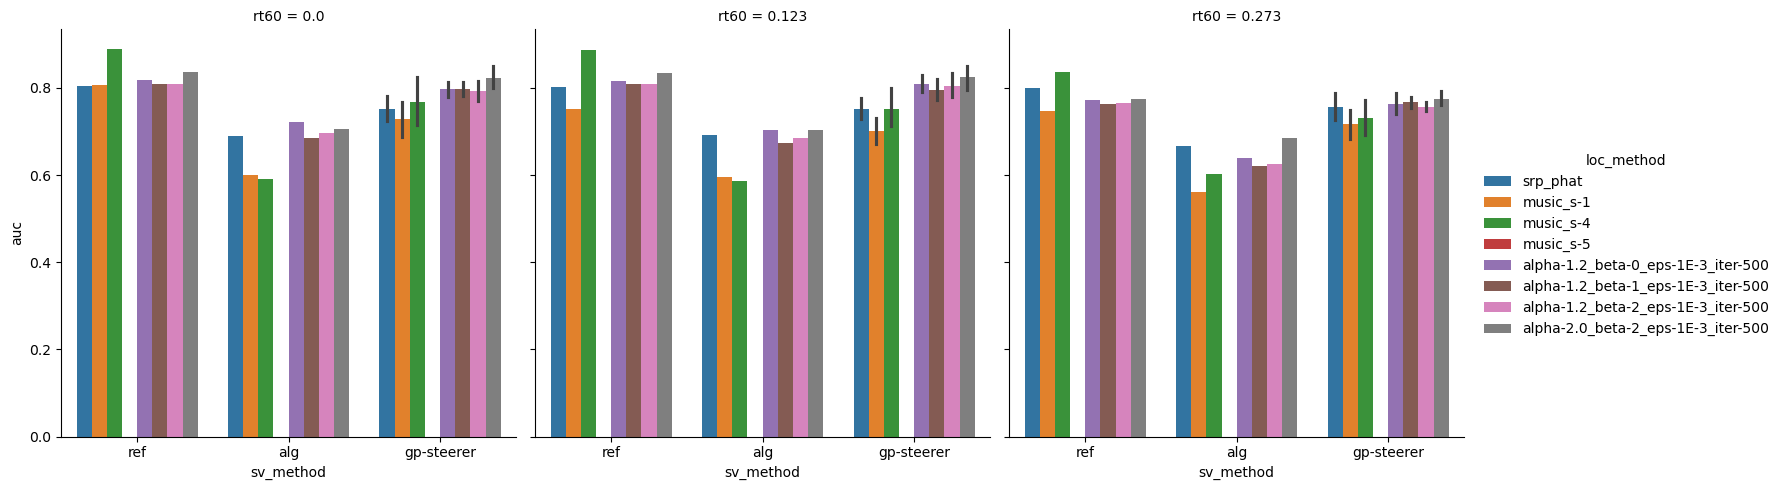

In [48]:
hue_order = [
    'srp_phat', 'music_s-1', 'music_s-4', 'music_s-5',
    'alpha-1.2_beta-0_eps-1E-3_iter-500',
    'alpha-1.2_beta-1_eps-1E-3_iter-500',
    'alpha-1.2_beta-2_eps-1E-3_iter-500',
    'alpha-2.0_beta-2_eps-1E-3_iter-500',
]
sns.catplot(data=auc_df, hue='loc_method', y='auc', x='sv_method', col='rt60', kind='bar', sharey=True, hue_order=hue_order)

Text(0.5, 1.05, 'AUC for different methods with GP-Steerer fit on nObs=8\n n_sources = 7')

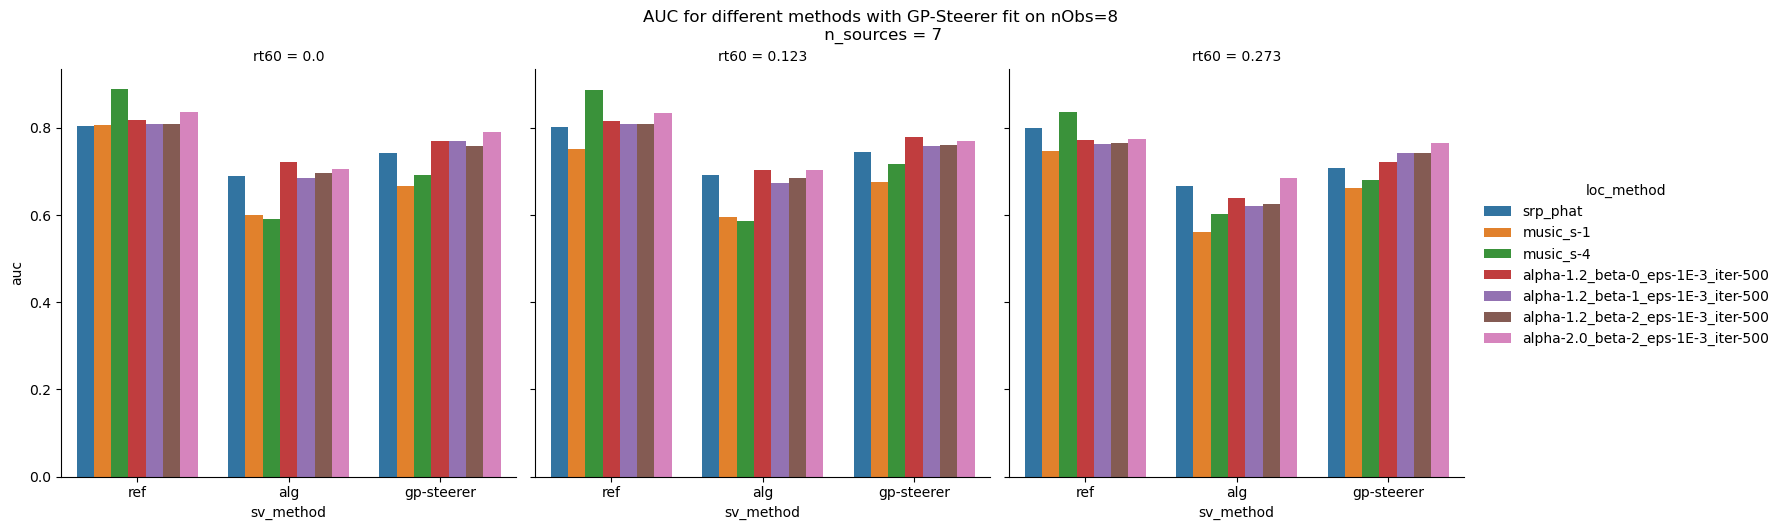

In [49]:
hue_order = [
    'srp_phat', 'music_s-1', 'music_s-4',
    'alpha-1.2_beta-0_eps-1E-3_iter-500',
    'alpha-1.2_beta-1_eps-1E-3_iter-500',
    'alpha-1.2_beta-2_eps-1E-3_iter-500',
    'alpha-2.0_beta-2_eps-1E-3_iter-500',
]

# if sv_method is gp-steerer then use nObs = XXX
auc_df_ = auc_df[
    (auc_df['sv_method'].isin(['ref', 'alg']))
    | (auc_df['sv_method'].isin(['gp-steerer']) & (auc_df['nObs'] == 8))
]

ax = sns.catplot(data=auc_df_, hue='loc_method', y='auc', x='sv_method', col='rt60', kind='bar', sharey=True, hue_order=hue_order)
plt.suptitle(f'AUC for different methods with GP-Steerer fit on nObs=8\n n_sources = {n_sources}', y=1.05)

# Plot angular spectrograms

nSrc-7_doas-[52 24  3  8  0 21 19]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.0_mc-3
[52 24  3  8  0 21 19]
alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True
alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True
music_s-4_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True
srp_phat_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True
alpha-1.2_beta-1_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True
music_s-1_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True
alpha-1.2_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True


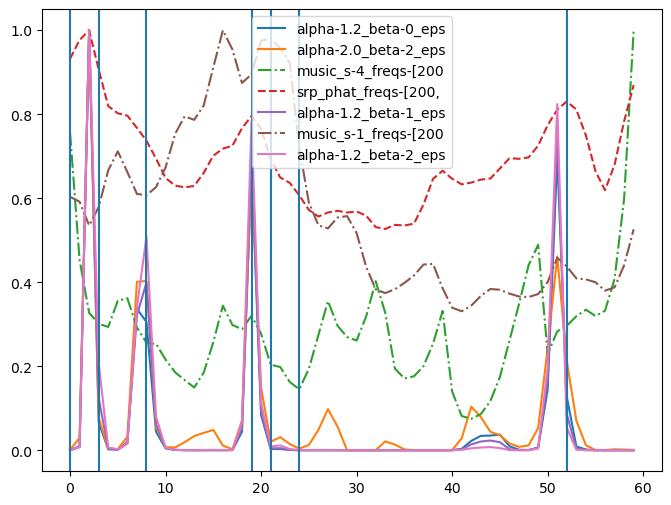

In [50]:
frame_id = unique_frame_ids[3]
print(frame_id)

curr_df = df_results_thr[
    df_results_thr['frame_id'] == frame_id
]
true_azimuths = curr_df['doas_ref_idx'].unique()
print(true_azimuths)

method_ids = auc_df_['method_id'].unique()

plt.figure(figsize=(8,6))
for method_id in method_ids:
    
    if not 'gp-steerer' in method_id:
        continue
    
    print(method_id)
    
    ang_spec = ang_specs_dicts[frame_id][method_id]['ang_spec']
    ang_spec = ang_spec.mean(-1)
    ang_spec /= np.max(ang_spec) 
    
    label = method_id[:20]
    
    if 'srp' in method_id:
        plt.plot(ang_spec, '--', label=label)
    elif 'music' in method_id:
        plt.plot(ang_spec, '-.', label=label)
    else:
        plt.plot(ang_spec, '-', label=label)
        
for az in true_azimuths:
    plt.axvline(x=az)
    
plt.legend()
plt.show()

nSrc-7_doas-[57  4 35 19 23 49 38]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.273_mc-7
[57  4 35 19 23 49 38]
alpha-1.2_beta-0_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True
alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True
music_s-4_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True
srp_phat_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True
alpha-1.2_beta-1_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True
music_s-1_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True
alpha-1.2_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True


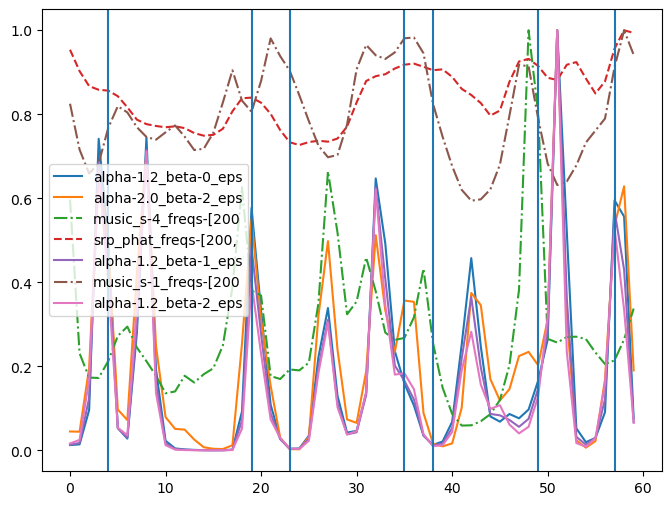

In [51]:
frame_id = unique_frame_ids[20]
print(frame_id)

curr_df = df_results_thr[
    df_results_thr['frame_id'] == frame_id
]
true_azimuths = curr_df['doas_ref_idx'].unique()
print(true_azimuths)

method_ids = auc_df_['method_id'].unique()

plt.figure(figsize=(8,6))
for method_id in method_ids:
    
    if not 'gp-steerer' in method_id:
        continue
    
    print(method_id)
    
    ang_spec = ang_specs_dicts[frame_id][method_id]['ang_spec']
    ang_spec = ang_spec.mean(-1)
    ang_spec /= np.max(ang_spec) 
    
    label = method_id[:20]
    
    if 'srp' in method_id:
        plt.plot(ang_spec, '--', label=label)
    elif 'music' in method_id:
        plt.plot(ang_spec, '-.', label=label)
    else:
        plt.plot(ang_spec, '-', label=label)
        
for az in true_azimuths:
    plt.axvline(x=az)
    
plt.legend()
plt.show()